In [4]:
from data_processing import *
from plot_functions import *
import argparse
import numpy as np
import pandas as pd
import glob
import os
from pymol import cmd

parser = argparse.ArgumentParser(description='Statistical analysis of HDX/MS data for curated RbsR peptides in one or more functional states.')
parser.add_argument('--pm', dest='pm', help="path to pymol structure", required=True)
parser.add_argument('--t', '--table', dest='table', help="path to uptake table", nargs='+', required=True)
parser.add_argument('--r', '--ranges', dest='ranges', help='path to ranges list csv')
parser.add_argument('--e', '--exclude', dest='exclude', action='store_true', help='exclude rather than include rangeslist')
parser.add_argument('--s1', dest='s1', help='first state to compare')
parser.add_argument('--s2', dest='s2', help='second state to compare')
parser.add_argument('--compare', dest='compare', help='dna, ligand, both', nargs=3)
parser.add_argument('--cbarmax', dest='cbarmax', type=float, help='max value for colorbar axis for dDbar')
parser.add_argument('--ldmin', dest='ldmin', type=float, help='in dDbar, minimum difference threshold between ligand/dna states')
parser.add_argument('--o', dest='outdir', help='path to output directory')
parser.add_argument('--sub', dest='subtract', action='store_true', help='subtract peptides from each other to get more peptides and higher resolution') 



args = parser.parse_args(args=['--t', './EcPFK_20230707_BioRep1/peptide_pool_20230724.csv','./EcPFK_20230424/peptide_pool_20230502.csv'
                               '--r', './EcPFK_20230707_BioRep1/ranges_list_e.csv', 
                               '--pm', '../example/2dri_protein.pdb','--o','/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/testing', '--sub',])


In [5]:
args.tables = ['/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep1_TechRep1_peptide_pool_result.csv', '/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep1_TechRep2_peptide_pool_result.csv', '/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep1_TechRep3_peptide_pool_result.csv', '/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep2_TechRep1_peptide_pool_result.csv', '/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep2_TechRep2_peptide_pool_result.csv'] 
args.ranges = ['/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep1_TechRep1_peptide_rangelist.csv', '/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep1_TechRep2_peptide_rangelist.csv', '/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep1_TechRep3_peptide_rangelist.csv', '/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep2_TechRep1_peptide_rangelist.csv', '/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep2_TechRep2_peptide_rangelist.csv']
args.pm = '/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/1pfk_Xray.pdb'
args.exclude = False

In [6]:
# load the data
hdxms_data_list = []
for i in range(len(args.tables)):

    if args.exclude:
        cleaned = read_hdx_tables(args.tables[i], args.ranges[i], exclude=True)
        hdxms_data = load_dataframe_to_hdxmsdata(cleaned)
        hdxms_data.reindex_peptide_from_pdb(args.pm, first_residue_index=1)
    else:
        print(args.tables[i])
        cleaned = read_hdx_tables([args.tables[i]], [args.ranges[i]])
        hdxms_data = load_dataframe_to_hdxmsdata(cleaned)
        hdxms_data.reindex_peptide_from_pdb(args.pm, first_residue_index=1)
    
    hdxms_data_list.append(hdxms_data)

/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep1_TechRep1_peptide_pool_result.csv
rangeslist included !
Peptide reindexed with offset -13
/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep1_TechRep2_peptide_pool_result.csv
rangeslist included !
Peptide reindexed with offset -13
/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep1_TechRep3_peptide_pool_result.csv
rangeslist included !
Peptide reindexed with offset -13
/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep2_TechRep1_peptide_pool_result.csv
rangeslist included !
Peptide reindexed with offset -13
/Users/belensundberg/Desktop/Glasgow_Lab/github_projects/Glasgow_Github/PIGEON/example/EcPFK_HDX_NEW_20230908/csv/EcPFK_BioRep2_Tech

In [7]:
def read_hdx_tables(tables, ranges, exclude=False):
    newbigdf = pd.DataFrame()
    cleaned_list = []
    
    # Process all tables
    for table, range_file in zip(tables, ranges):
        newbigdf = process_table(table)

        # Convert columns to the appropriate data types
        newbigdf['Start'] = newbigdf['Start'].apply(np.int64)
        newbigdf['End'] = newbigdf['End'].apply(np.int64)
        newbigdf['#D'] = newbigdf['#D'].apply(float)

        cleaned = load_ranges_file(range_file, newbigdf, exclude)
        cleaned_list.append(cleaned)

    cleaned = pd.concat(cleaned_list, ignore_index=True)
    cleaned = clean_data_df(cleaned)
    
    return cleaned

In [20]:
# #define 3 states to overwrite the next cell (loads all states) -- CL will fix this package

# def read_hdx_tables(tables, ranges, exclude=False, only_states=['APO', 'ADP', 'PEP']):
#     newbigdf = pd.DataFrame()
#     cleaned_list = []
#     # Process all tables
#     for table, range_file in zip(tables, ranges):
#         newbigdf = process_table(table)
#         # Convert columns to the appropriate data types
#         newbigdf['Start'] = newbigdf['Start'].apply(np.int64)
#         newbigdf['End'] = newbigdf['End'].apply(np.int64)
#         newbigdf['#D'] = newbigdf['#D'].apply(float)
#         cleaned = load_ranges_file(range_file, newbigdf, exclude)
#         cleaned_list.append(cleaned)
#     cleaned = pd.concat(cleaned_list, ignore_index=True)
#     cleaned = clean_data_df(cleaned)
#     state_mask = cleaned['Protein State'].isin(only_states)
#     cleaned = cleaned[state_mask]
#     return cleaned

In [6]:
#How many states are we currently considering?
#print(len([i.state_name for i in hdxms_data.states]))
#What are the states we are considering? 
#print(str([i.state_name for i in hdxms_data.states]) + "\n")

num_states=len([i.state_name for data in hdxms_data_list for i in data.states])
#How many states?
print(f'There are {num_states} states in the data.')
#What are the states?
print([i.state_name for data in hdxms_data_list for i in data.states ])

There are 18 states in the data.
['ADP', 'APO', 'CIT', 'PEP', 'ADP', 'APO', 'CIT', 'FUM', 'PEP', 'ADP', 'APO', 'PEP', 'ADP', 'APO', 'PEP', 'ADP', 'APO', 'PEP']


In [22]:
# Add new peptides to protein state after subtraction 
[state.add_all_subtract() for data in hdxms_data_list for state in data.states]

230 new peptides added to the protein state.
85 new peptides added to the protein state.
47 new peptides added to the protein state.
6 new peptides added to the protein state.
4 new peptides added to the protein state.
0 new peptides added to the protein state.
230 new peptides added to the protein state.
85 new peptides added to the protein state.
47 new peptides added to the protein state.
6 new peptides added to the protein state.
4 new peptides added to the protein state.
0 new peptides added to the protein state.
229 new peptides added to the protein state.
85 new peptides added to the protein state.
46 new peptides added to the protein state.
3 new peptides added to the protein state.
5 new peptides added to the protein state.
4 new peptides added to the protein state.
0 new peptides added to the protein state.
227 new peptides added to the protein state.
85 new peptides added to the protein state.
44 new peptides added to the protein state.
3 new peptides added to the protein st

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [8]:
# num of the unique peptides
peptides_all = []
for i in hdxms_data_list: #hdx_data_list is a list of data objects
    for state in i.states:
       peptides_all += state.peptides #add value to peptides_all list
peptides_all_seq = [pep.sequence for pep in peptides_all] # create a new list peptides_all_seq by extracting the sequence from each peptide object in peptides_all
peptides_all_seq_unique = list(set(peptides_all_seq)) #converts peptides_all_seq into a set to remove any duplicate peptide sequences then converts to a list
print(len(peptides_all_seq_unique)) #prints the number of unique peptides

845


5.634123518402994


Text(0.5, 0, 'Peptide length')

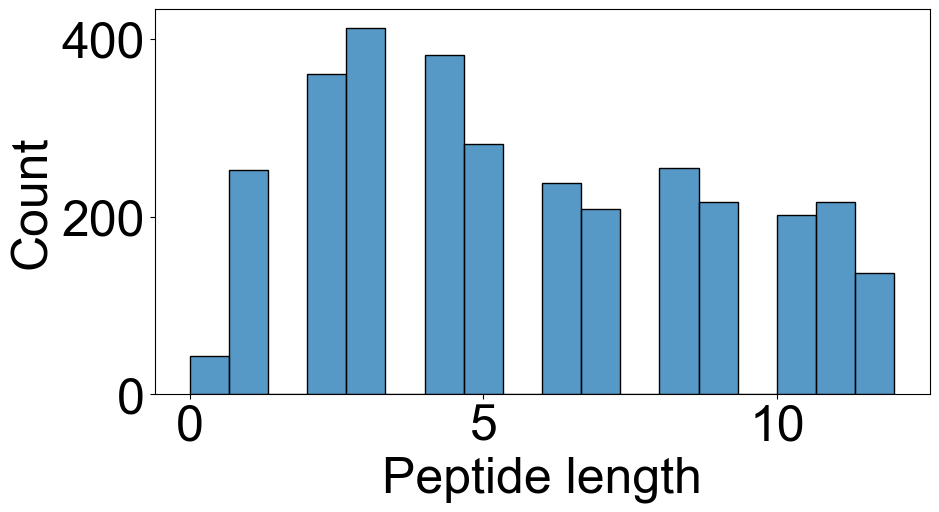

In [5]:
# # Make a histogram of peptide length vs. count (BAD PLOT)

# length_array = np.array([len(pep.sequence[2:]) for pep in peptides_all])
# print(length_array.mean())
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.histplot(length_array)
# #ax.set_xticks(range(0,15))
# ax.set_xlabel('Peptide length')


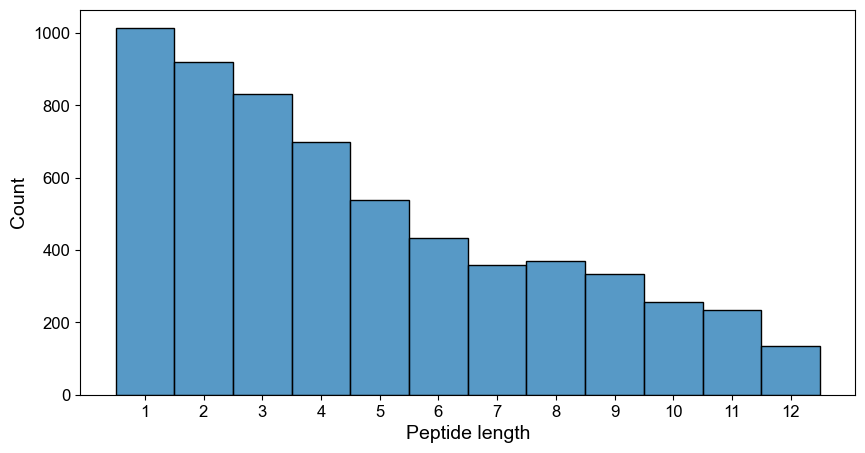

In [6]:
# make histogram of the peptide length data EDITED (better plot)
# Your data
length_array = np.array([len(pep.sequence[2:]) for pep in peptides_all])

# Filter out peptides with length 0
length_array = np.array([len(pep.sequence[2:]) for pep in peptides_all if len(pep.sequence[2:]) > 0])

# Manually specify bin edges to center the bars on the ticks
bins = [x - 0.5 for x in range(1,14)]  # Center the bars on integer tick positions

# Create the histogram
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(length_array, bins=bins, kde=False)

# Set x-axis ticks
ax.set_xticks(range(1, 13))

# Set x-axis and y-axis labels
ax.set_xlabel('Peptide length', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

# Set the tick label font size
ax.tick_params(axis='both', labelsize=12)

plt.show()


In [13]:
# Create a dictionary to store the counts for each length
length_counts = {length: 0 for length in range(16)}

# Count the peptides for each length
for pep in peptides_all:
    length = len(pep.sequence[2:])
    if length in length_counts:
        length_counts[length] += 1

# Print the counts
for length, count in length_counts.items():
    print(f"Number of peptides with length {length}: {count}")


Number of peptides with length 0: 1637
Number of peptides with length 1: 820
Number of peptides with length 2: 753
Number of peptides with length 3: 667
Number of peptides with length 4: 558
Number of peptides with length 5: 428
Number of peptides with length 6: 348
Number of peptides with length 7: 287
Number of peptides with length 8: 292
Number of peptides with length 9: 271
Number of peptides with length 10: 203
Number of peptides with length 11: 187
Number of peptides with length 12: 102
Number of peptides with length 13: 0
Number of peptides with length 14: 0
Number of peptides with length 15: 0


In [25]:
# #output text document with the peptide sequence, peptide sequence without the N-terminal 2 resi, and peptide length after subtracting N-term 2 resi
# length_array = np.array([len(pep.sequence[2:]) for pep in peptides_all])

# for pep in peptides_all:
#     #print(str(pep.sequence) + " " + str(pep.sequence[2:])+ " " + str(len(pep.sequence[2:])) )

# # Open a text file for writing
# with open('output.txt', 'w') as file:
#     for pep in peptides_all:
#         line = f"{pep.sequence} {pep.sequence[2:]} {len(pep.sequence[2:])}\n"
#         file.write(line)

In [9]:
# Calculate the average peptide coverage per residue 

coverage = []
for resid in range(1,320):
    pep_contain = []
    for pep in peptides_all:
        if resid >= pep.start and resid <= pep.end: #if resid is within the range defined by the start and end attributes of the peptide, add the peptide to the list pep_contain
            pep_contain.append(pep)
    coverage.append(len(pep_contain))
print(np.average(coverage)) #  need to be divided by the num of the states to get coverage/state
#ie. average 50 peptides cover that residue 

print("The average peptide coverage per residue is: " + str((np.average(coverage))/num_states)) #divide by n states


137.141065830721
The average peptide coverage per residue is: 7.618948101706723


In [13]:
# df = revert_hdxmsdata_to_dataframe(hdxms_data_list[0])

In [14]:
# df = revert_hdxmsdata_to_dataframe(hdxms_data_list[0])

# convert_dataframe_to_bayesianhdx_format(df, protein_name='EcPFK', OUTPATH='/Users/belensundberg/Desktop/EcPFK_HDX_NEW_20230908/test-subtract-20231017/3_states')

Data saved to /Users/belensundberg/Desktop/EcPFK_HDX_NEW_20230908/test-subtract-20231017/3_states


In [259]:
# # States and number of subtracted peptides added to each state
# [(state.state_name, state.num_subtracted_added) for data in hdxms_data_list for state in data.states]

[('ADP', 372),
 ('APO', 372),
 ('PEP', 368),
 ('ADP', 291),
 ('APO', 294),
 ('PEP', 315),
 ('ADP', 284),
 ('APO', 282),
 ('PEP', 273),
 ('ADP', 116),
 ('APO', 114),
 ('PEP', 117),
 ('ADP', 259),
 ('APO', 248),
 ('PEP', 250)]

In [27]:
# List of single residue peptides
single = [peptide for data in hdxms_data_list for state in data.states for peptide in state.peptides if len(peptide.sequence) == 1] 

single_peptides = (sorted(list(set([i.start for i in single]))))
print(single_peptides)
print("The total number of single residue peptides is: " + str(len(single_peptides)))

[-2, -1, 3, 6, 9, 10, 19, 20, 21, 22, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 50, 53, 54, 55, 62, 63, 64, 65, 66, 69, 70, 71, 74, 77, 82, 85, 86, 87, 91, 92, 97, 98, 100, 113, 118, 120, 121, 122, 129, 130, 141, 142, 143, 152, 155, 158, 166, 173, 174, 182, 189, 191, 197, 198, 199, 200, 201, 202, 203, 205, 207, 208, 222, 225, 226, 227, 228, 229, 230, 231, 232, 249, 250, 256, 267, 268, 275, 276, 277, 278, 279, 282, 283, 284, 285, 286, 287, 288, 289, 290, 292, 294, 295, 296, 300, 301, 305, 314, 315, 316, 317, 318]
The total number of single residue peptides is: 115


In [ ]:
# Make uptake plot as an example
#for pep in hdxms_data_list[0].states[1].peptides:
    #uptake = UptakePlot(hdxms_data_list, pep.identifier)
    #fig = uptake.uptakeplot
    #fig.savefig(f"/Users/belensundberg/Desktop/EcPFK_HDX_NEW_20230908/test-nosubtract-20231017/{pep.identifier}.png")

In [19]:
# all_data = pd.concat([revert_hdxmsdata_to_dataframe(i) for i in hdxms_data_list]).reset_index(drop=True)

In [28]:
# # Convert df to bayesian hdx format
# convert_dataframe_to_bayesianhdx_format(all_data, protein_name='1PFK', OUTPATH='/Users/belensundberg/Desktop/EcPFK_HDX_NEW_20230908/test-subtract-20231017/3_states')

# Make uptake plot

In [ ]:
#uptake = UptakePlot(hdxms_data_list, '113-126 GDYIAKKAGEGAKV')

In [20]:
#uptake.get_average_peptide('APO').new_fit()

In [21]:
#uptake.uptakeplot

# Make uptake plot for all peptides in hdxms data

In [29]:
# # make a uptake plot for all the peptides in hdxms_data
# uptakes = UptakePlotsCollection(if_plot_fit=True)
# uptakes.add_plot_all(hdxms_data_list)
# # save all the plots
# uptakes.save_plots('/Users/belensundberg/Desktop/EcPFK_HDX_NEW_20230908/test-subtract-20231017/3_states')

### plot to pymol

In [8]:
# Code from plot_functions.py for testing in this notebook
def create_compare_pymol_plot(compares, colorbar_max, colormap="RdBu", pdb_file=None, path=None,
                              save_pdb=False):

    rgb_df = gen_rgb_df(compares, colorbar_max, colormap)

    from pymol import cmd
    cmd.delete('all')
    cmd.load(pdb_file)
    cmd.color("gray")


    if isinstance(compares, HDXStatePeptideCompares):
        for i, seq in enumerate(rgb_df['title']):
            split_seq = seq.split()
            seq=seq.split()[-1]
            if len(split_seq) > 0:
                resi = split_seq[0]  # Access the first part of the split
            if "-" == resi[0]:
                continue
            if "--" in resi:
                continue
                cmd.select(seq, 'resi ' + resi)
                cmd.set_color(seq, [rgb_df['r'][i], rgb_df['g'][i], rgb_df['b'][i]])
                cmd.color(seq, seq)


    elif isinstance(compares, HDXStateResidueCompares):
            for i, seq in enumerate(rgb_df['title']):
                if np.isnan(rgb_df['s'].values[i]):
                    continue
                parts = seq.split()
                if len(parts) > 0:
                    resi = parts[0]  # Extract the first part (e.g., "ABC")
                    cmd.select(seq, 'resi ' + resi)
                    cmd.set_color(f'res_{seq}', [rgb_df['r'][i], rgb_df['g'][i], rgb_df['b'][i]])
                    cmd.color(f'res_{seq}', seq)
                    cmd.delete(seq)
        
    cmd.ray(1000,1000)
        
    if path is not None:
        if isinstance(compares, HDXStatePeptideCompares):
            full_path = os.path.join(path, f'{compares.state1_list[0].state_name}-{compares.state2_list[0].state_name}_{colorbar_max}_pepcompare-pm.pse')
        elif isinstance(compares, HDXStateResidueCompares):
            full_path = os.path.join(path, f'{compares.state1_list[0].state_name}-{compares.state2_list[0].state_name}_{colorbar_max}_rescompare-pm.pse')
            cmd.save(full_path)
    else:
        raise ValueError('Please provide a path to save the pymol session')
        
    if isinstance(compares, HDXStateResidueCompares):
        if save_pdb:
            pdb_full_path = os.path.join(path, f'{compares.state1_list[0].state_name}-{compares.state2_list[0].state_name}_rescompare-pm.pdb')
            save_pdb = plot_on_pdb(pdb_file, compares, pdb_full_path)



In [ ]:
# # Code from plot_functions.py for testing in this notebook
# def create_compare_pymol_plot(compares, colorbar_max, colormap="RdBu", pdb_file=None, path=None,
#                               save_pdb=False):

#     rgb_df = gen_rgb_df(compares, colorbar_max, colormap)

#     from pymol import cmd
#     cmd.delete('all')
#     cmd.load(pdb_file)
#     cmd.color("gray")


#     if isinstance(compares, HDXStatePeptideCompares):
#         for i, seq in enumerate(rgb_df['title']):
#             split_seq = seq.split()
#             seq=seq.split()[-1]
#             if len(split_seq) > 0:
#                 resi = split_seq[0]  # Access the first part of the split
#             if "-" == resi[0]:
#                 continue
#             if "--" in resi:
#                 continue
#                 cmd.select(seq, 'resi ' + resi)
#                 cmd.set_color(seq, [rgb_df['r'][i], rgb_df['g'][i], rgb_df['b'][i]])
#                 cmd.color(seq, seq)


#     elif isinstance(compares, HDXStateResidueCompares):
#             for i, seq in enumerate(rgb_df['title']):
#                 if np.isnan(rgb_df['s'].values[i]):
#                     continue
#                 parts = seq.split()
#                 if len(parts) > 0:
#                     resi = parts[0]  # Extract the first part (e.g., "ABC")
#                     cmd.select(seq, 'resi ' + resi)
#                     cmd.set_color(f'res_{seq}', [rgb_df['r'][i], rgb_df['g'][i], rgb_df['b'][i]])
#                     cmd.color(f'res_{seq}', seq)
#                     cmd.delete(seq)
        
#     cmd.ray(1000,1000)
        
#     if path is not None:
#         if isinstance(compares, HDXStatePeptideCompares):
#             full_path = os.path.join(path, f'{compares.state1_list[0].state_name}-{compares.state2_list[0].state_name}_{colorbar_max}_pepcompare-pm.pse')
#         elif isinstance(compares, HDXStateResidueCompares):
#             full_path = os.path.join(path, f'{compares.state1_list[0].state_name}-{compares.state2_list[0].state_name}_{colorbar_max}_rescompare-pm.pse')
#             cmd.save(full_path)
#     else:
#         raise ValueError('Please provide a path to save the pymol session')
        
#     if isinstance(compares, HDXStateResidueCompares):
#         if save_pdb:
#             pdb_full_path = os.path.join(path, f'{compares.state1_list[0].state_name}-{compares.state2_list[0].state_name}_rescompare-pm.pdb')
#             save_pdb = plot_on_pdb(pdb_file, compares, pdb_full_path)



In [ ]:
# # Backup code from when I was troubleshooting above cell
#     if isinstance(compares, HDXStatePeptideCompares):
#         for i, seq in enumerate(rgb_df['title']):
#             split_seq = seq.split()
#             seq=seq.split()[-1]
#             if len(split_seq) > 0:
#                 resi = split_seq[0]  # Access the first part of the split
#             if "-" == resi[0]:
#                 continue
#             if "--" in resi:
#                 continue
#                 cmd.select(seq, 'resi ' + resi)
#                 cmd.set_color(seq, [rgb_df['r'][i], rgb_df['g'][i], rgb_df['b'][i]])
#                 cmd.color(seq, seq)
#     elif isinstance(compares, HDXStateResidueCompares):
#             for i, seq in enumerate(rgb_df['title']):
#                 if np.isnan(rgb_df['s'].values[i]):
#                     continue
#                 parts = seq.split()
#                 if len(parts) > 0:
#                     resi = parts[0]  # Extract the first part (e.g., "ABC")
#                     cmd.select(seq, 'resi ' + resi)
#                     cmd.set_color(f'res_{seq}', [rgb_df['r'][i], rgb_df['g'][i], rgb_df['b'][i]])
#                     cmd.color(f'res_{seq}', seq)
#                     cmd.delete(seq)

In [11]:
# Make pymol plots for the following pairs of states

from itertools import product

pairs = [('APO', 'ADP'), ('APO', 'PEP'), ('PEP', 'ADP')]


OUTDIR2 = '/Users/belensundberg/Desktop/testpymol'
if not os.path.exists(OUTDIR2):
    os.makedirs(OUTDIR2)

for state1_name, state2_name in pairs:

    state1_list = [i.get_state(state1_name) for i in hdxms_data_list]
    state2_list = [i.get_state(state2_name) for i in hdxms_data_list]

    compare = HDXStatePeptideCompares(state1_list, state2_list)
    compare.add_all_compare()

    create_compare_pymol_plot(compare, colorbar_max=0.2, pdb_file=args.pm, path=OUTDIR2)

    res_compares = HDXStateResidueCompares([i for i in range(1, 320)], state1_list, state2_list)
    res_compares.add_all_compare()

    create_compare_pymol_plot(res_compares, 0.2, pdb_file=args.pm, path=OUTDIR2)

In [234]:
#create_compare_pymol_plot(compare, colorbar_max=0.05, pdb_file='../example/2dri_protein.pdb', path='/Users/chenlin/Downloads/')

### make all the plots and save them




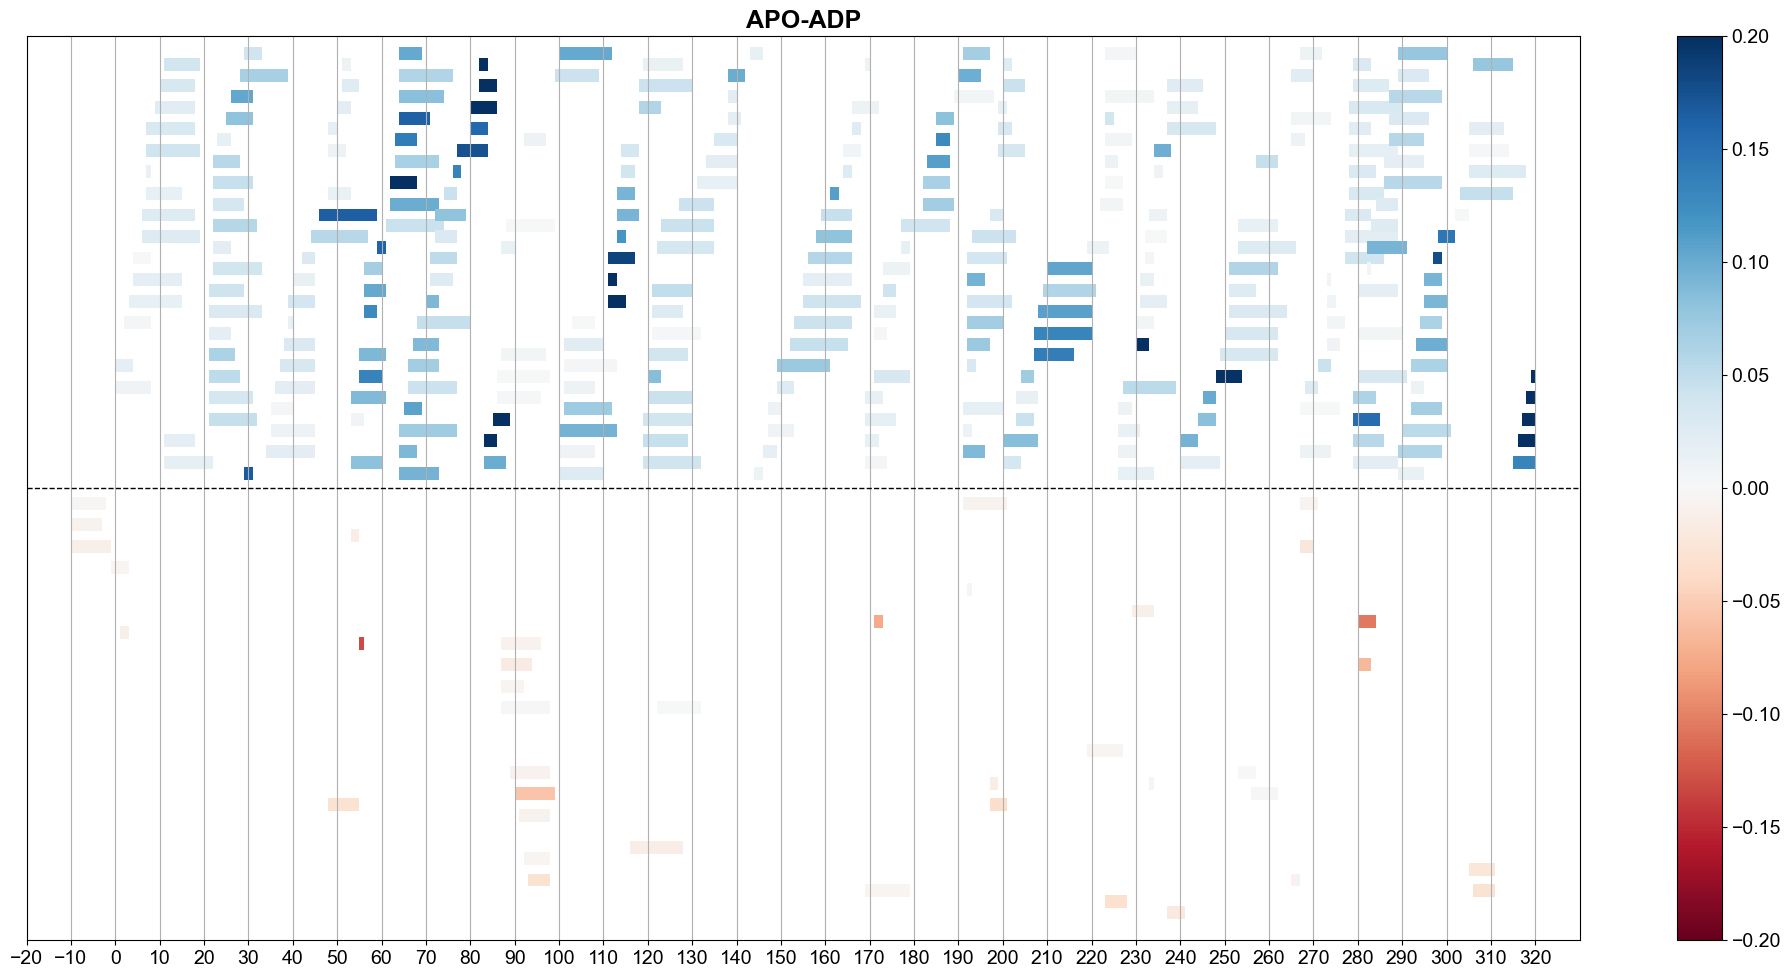

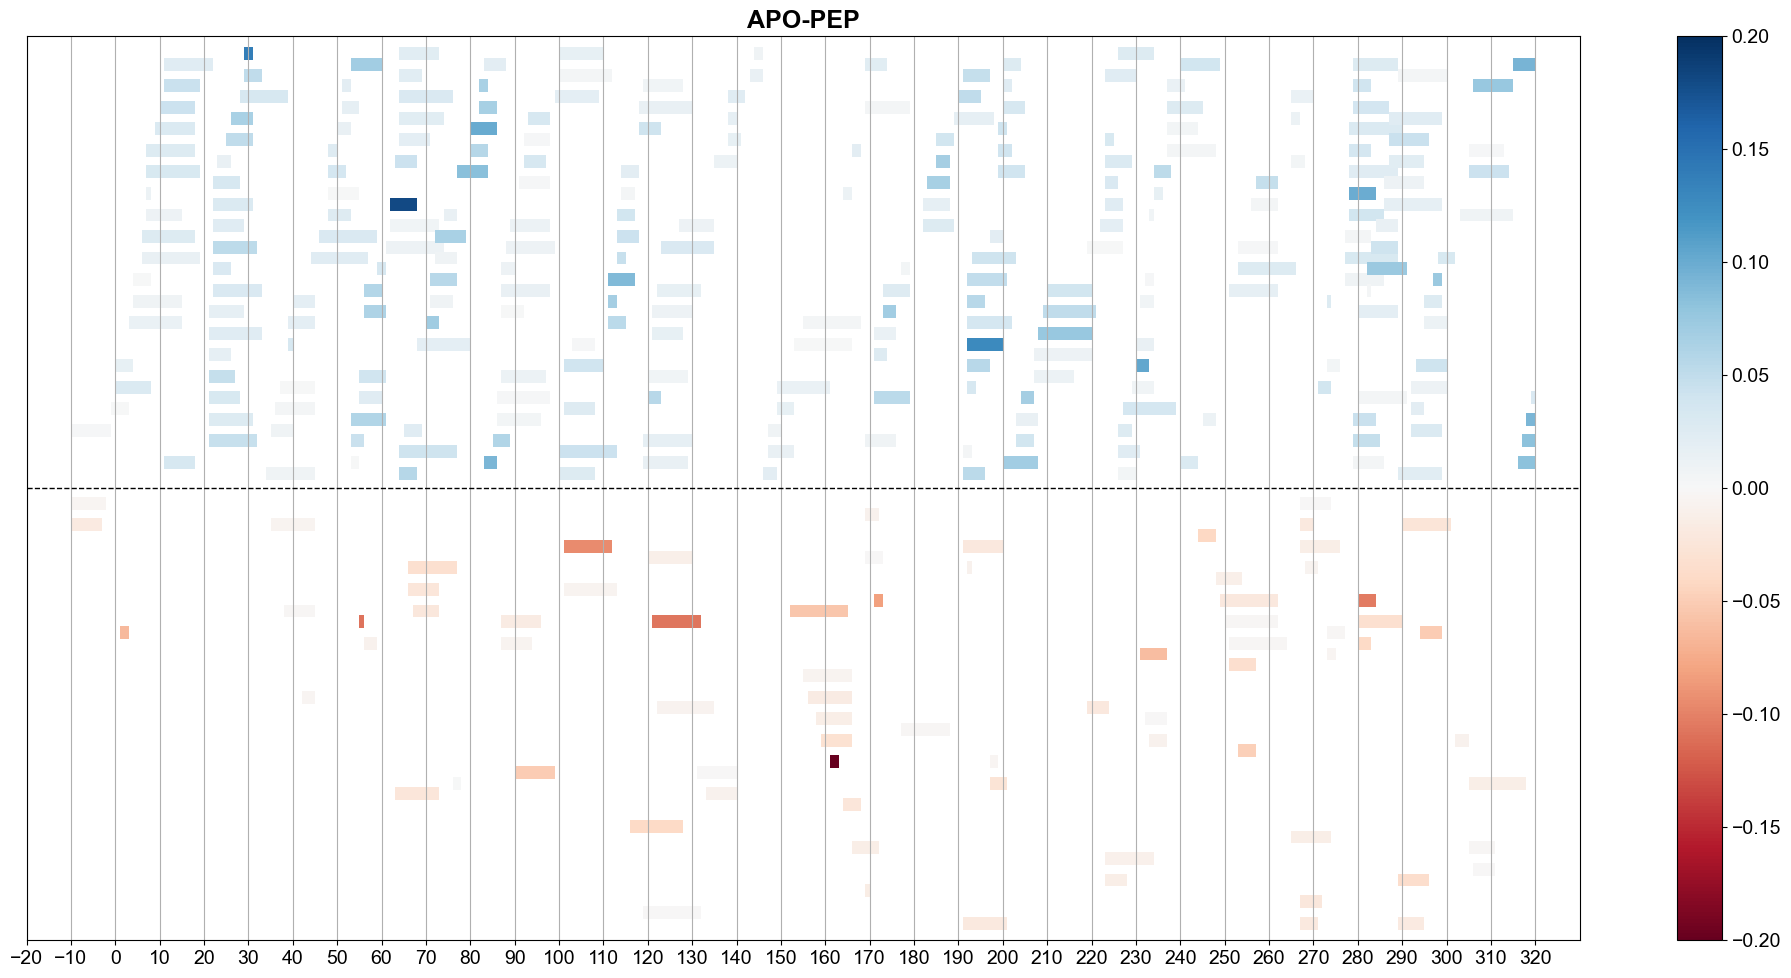

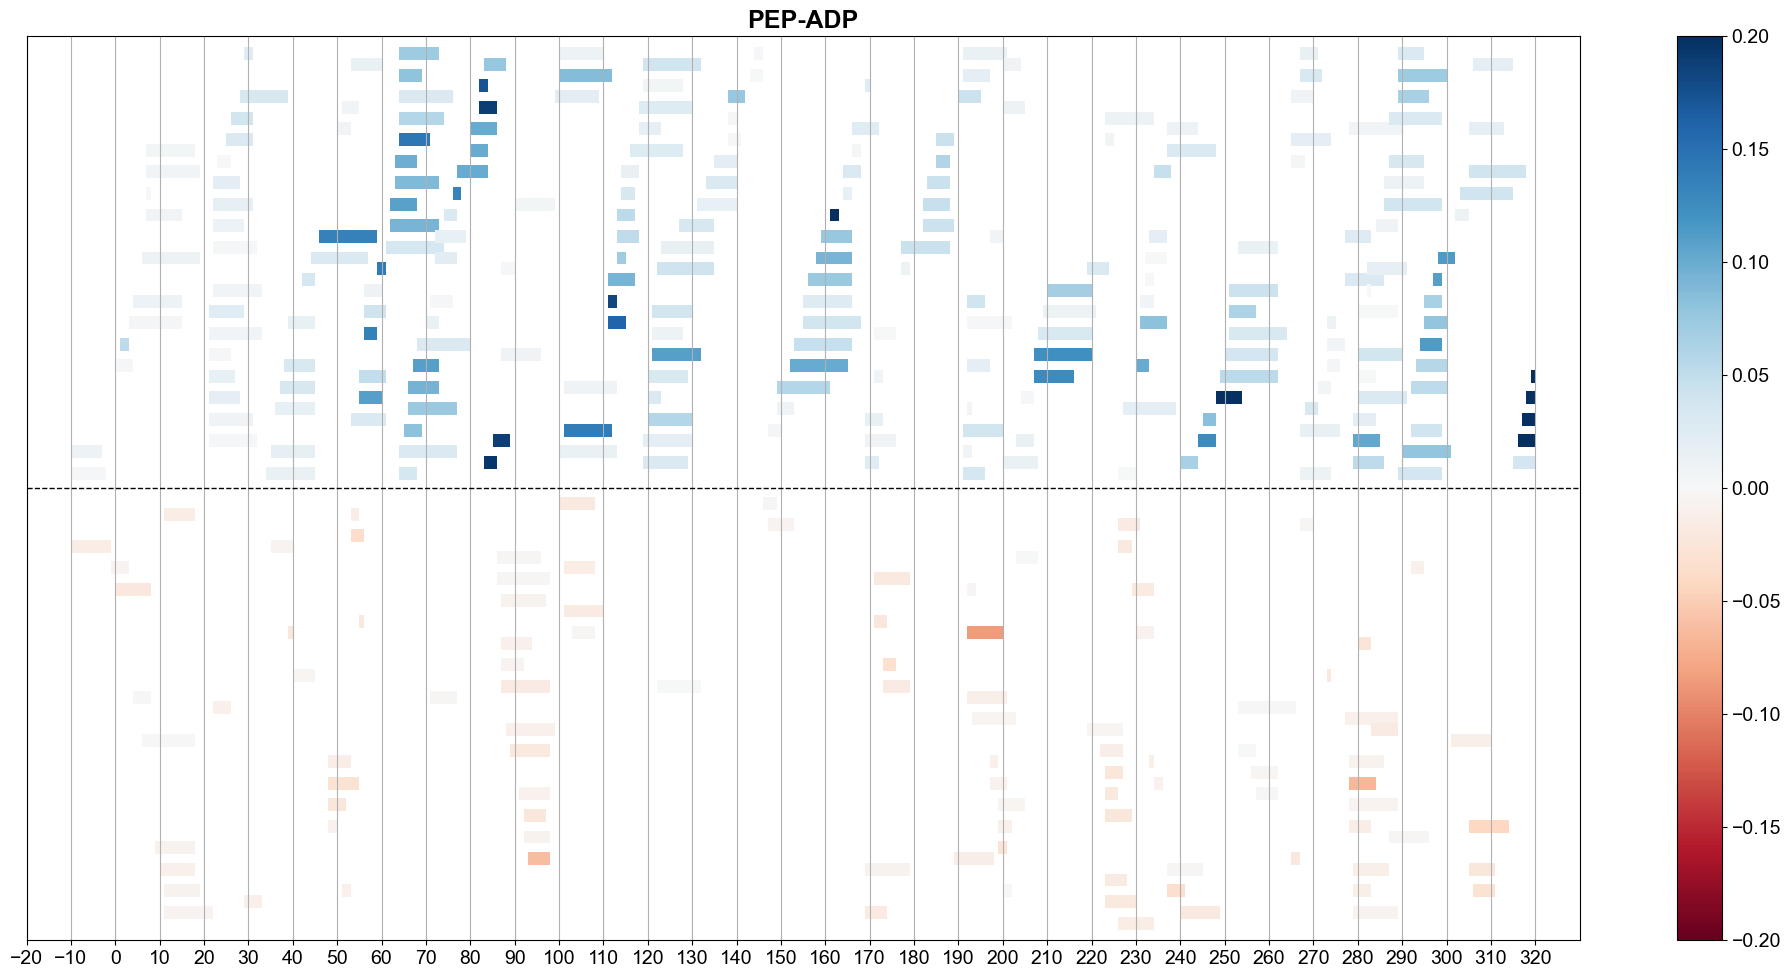

In [9]:
from itertools import product

pairs = [('APO', 'ADP'), ('APO', 'PEP'), ('PEP', 'ADP')]


OUTDIR = '/Users/belensundberg/Desktop/EcPFK_HDX_NEW_20230908/test-subtract-20231017/heatmap_sep'
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

for state1_name, state2_name in pairs:

    state1_list = [i.get_state(state1_name) for i in hdxms_data_list]
    state2_list = [i.get_state(state2_name) for i in hdxms_data_list]

    compare = HDXStatePeptideCompares(state1_list, state2_list)
    compare.add_all_compare()

    heatmap_compare_tp = create_heatmap_compare_tp(compare, 0.2)
    #heatmap_compare_tp.savefig(f'{OUTDIR}/{state1_name}-{state2_name}-heatmap-tp.png')

    heatmap_compare = create_heatmap_compare(compare, 0.2)
    #heatmap_compare.savefig(f'{OUTDIR}/{state1_name}-{state2_name}-heatmap.png')

    heatmap_compare_separated = create_heatmap_with_dotted_line(compare,0.2)
    #heatmap_compare_separated.savefig(f'{OUTDIR}/{state1_name}-{state2_name}-heatmap-sep.png')

    create_compare_pymol_plot(compare, colorbar_max=0.2, pdb_file=args.pm, path=OUTDIR)


    res_compares = HDXStateResidueCompares([i for i in range(1, 320)], state1_list, state2_list)
    res_compares.add_all_compare()

    #create_compare_pymol_plot(res_compares, 0.2, pdb_file=args.pm, path=OUTDIR)

    


In [22]:
items =[state.state_name for state in hdxms_data.states]
combinations = product(['APO'], [x for x in items if x != 'APO'])

In [23]:
for state1_name, state2_name in combinations:
    print(state1_name, state2_name)

APO ADP
APO PEP


In [15]:
# Function to make a heatmap with positive and negative deuterium uptake values separated by a dotted line
# This was added to plot_functions.py

# Define 'items', 'combinations', and 'OUTDIR'

OUTDIR2="/Users/belensundberg/Desktop/EcPFK_HDX_NEW_20230908/test-nosubtract-20231017/new_heatmap_sep"

def create_heatmap_with_dotted_line(compare, colorbar_max, colormap="RdBu"):
    font = {'family': 'Arial',
            'weight': 'normal',
            'size': 14
        }
    axes = {'titlesize': 18,
            'titleweight': 'bold',
            'labelsize': 16
        }

    plt.rc('font', **font)
    plt.rc('axes', **axes)

    plt.rcParams['figure.figsize'] = (4, 25)
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] = 'Arial'
    colormap = cm.get_cmap(colormap)

    fig, ax = plt.subplots(figsize=(20, 10))

    leftbound = compare.peptide_compares[0].peptide1_list[0].start - 10
    rightbound = compare.peptide_compares[-1].peptide1_list[0].end + 10
    ax.set_xlim(leftbound, rightbound)
    ax.xaxis.set_ticks(np.arange(round(leftbound, -1), round(rightbound, -1), 10))
    y_min = -105
    y_max = 105
    ax.set_ylim(y_min, y_max)
    y_middle=(y_min+y_max)/2
    ax.grid(axis='x')
    ax.yaxis.set_ticks([])
    #add a horizontal dotted line that matches with the 0.0 on the colorbar
    ax.axhline(y=y_middle, color='k', linestyle='--', linewidth=1)

    norm = col.Normalize(vmin=-colorbar_max, vmax=colorbar_max)

    fig.colorbar(cm.ScalarMappable(cmap=colormap, norm=norm))

    for i,peptide_compare in enumerate(compare.peptide_compares):
            for peptide in peptide_compare.peptide1_list:
                deut_diff_avg = peptide_compare.deut_diff_avg
                #print(deut_diff_avg)
                
                if deut_diff_avg > 0:
                    y_position = (i % 20) * 5 + ((i // 20) % 2) * 2.5 + y_middle + 2
                    
                else:
                    y_position = y_middle - ((i % 20) * 5 + ((i // 20) % 2) * 2.5) - 5  # Below the line

                rect = Rectangle((peptide.start, y_position),
                                    peptide.end - peptide.start,
                                    3,
                                    fc=colormap(norm(deut_diff_avg)))
                ax.add_patch(rect)


    ax.set_title(compare.state1_list[0].state_name + '-' + compare.state2_list[0].state_name)
    fig.tight_layout()
            
    return fig


In [ ]:
pairs = [('APO', 'ADP') , ('APO', 'PEP'), ('PEP', 'ADP')]
combinations = pairs

for state1_name, state2_name in combinations:
    # Your existing code

    heatmap_compare_sep = create_heatmap_with_dotted_line(compare, 0.5, colormap="RdBu")
    #heatmap_compare.savefig(f'{OUTDIR2}/{state1_name}-{state2_name}-heatmap.png')
